# Making prediction of GOLD price 

For the first time we will use features of multiple financial instruments. In this case we will use the main Forex pairs and the SP500 to perform our forecasts on Gold. This Jupyter notebook will be your guide for more complex calculations. Obviously, you can change the features and instruments as you want or you need. That will be your own research. I have give you the guide.

### Problem definition

• Short-term forecasting: ∀t: given $x_t$ , predict  $x_{t+1}$

• Long-term forecasting: given a burn-in sequence $x_0$ , . . . , $x_{t_0}$ , predict $x_{t_0 +1}$, . . . , $x_{t_0+n}$ . For each t, the
model uses as input its previous prediction $\hat{x}_t$ . (Not in this Notebook!)

**Experiment conditions:**

* features = ["open", "high", "low", "close"] for each Forex pair and SPXUSD

* Features Normalization

We have the previous features in candles of one minute, but, to simplify, we will only use the opening price of each of the currency pairs. With these features we will calculate the opening price of the next one hour candle for **GOLD** (XAUUSD).

Finally we have to say that in some parts of the code, we have abused of pandas dataframes only with the aim of getting clear printable landscape of he working data. These lines of code is indicated with the comment "...as dataframe" and may be avoided if you translate this notebook to python scripts.

Again, we are going to follow our Supervised Learning Flowchart as we see below:

![supervised_learning_flowchart_avatar](../images/supervised_learning_flowchart_avatar.jpg)

## Load configuration

Below, it  is an example of .env file for your customization:
~~~~
PROJ_DIR=.
DATA_DIR=../data/
RAW_DIR=../data/raw/
INTERIM_DIR=../data/interim/
PROCESSED_DIR=../data/processed/
FIGURES_DIR=../reports/figures/
MODEL_DIR=../models/
EXTERNAL_DIR=../data/external/
PRODUCTION_DIR=/home/PRODUCTION/
~~~~

In [1]:
## 1. Import libraries and modules. Load env variables
import os
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import zipfile
import sqlite3
from datetime import date, datetime, timezone
from dotenv import find_dotenv, load_dotenv

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model.utils import build_tensor_info

from sklearn.preprocessing import MinMaxScaler
#from IPython.display import Image

#Reads the key,value pair from .env and adds them to environment variable 
load_dotenv(find_dotenv())

# Check the env variables exist. Check as many variables as you need
raw_msg = "Set your raw data absolute path in the .env file at project root"
assert "RAW_DIR" in os.environ, raw_msg
data_msg = "Set your processed data absolute path in the .env file at project root"
assert "DATA_DIR" in os.environ, data_msg
interim_msg = "Set your interim data absolute path in the .env file at project root"
assert "INTERIM_DIR" in os.environ, interim_msg

# Load env variables
proj_dir = os.path.expanduser(os.environ.get("PROJ_DIR"))
data_dir = os.path.expanduser(os.environ.get("DATA_DIR"))
raw_dir = os.path.expanduser(os.environ.get("RAW_DIR"))
interim_dir = os.path.expanduser(os.environ.get("INTERIM_DIR"))
processed_dir = os.path.expanduser(os.environ.get("PROCESSED_DIR"))
figures_dir = os.path.expanduser(os.environ.get("FIGURES_DIR"))
model_dir = os.path.expanduser(os.environ.get("MODEL_DIR"))
external_dir = os.path.expanduser(os.environ.get("EXTERNAL_DIR"))
production_dir = os.path.expanduser(os.environ.get("PRODUCTION_DIR"))

# Import our project modules
#
#Add src/app to the PATH
#Ram sys.path.append(os.path.join(proj_dir,"src/app"))

#Add src/data to the PATH
sys.path.append(os.path.join(proj_dir,"src/data"))
#Ram import make_dataset as md

#Add src/visualization to the PATH
#Ram sys.path.append(os.path.join(proj_dir,"src/visualization"))
#Ram import visualize as vs

#Data files
#raw_data = 
#interim_data = 

#Global configuration variables
# Send models to production env. folder (True: send. False: Do not send)
to_production = True

/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/parrondo/anaconda3/envs/deeptrading/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibili

## Ingest raw data

### Download raw datasets


The great people at [HistData.com](http://www.histdata.com/) have setup the infrastructure necessary to provide you FOREX data for free. This is awesome and if possible, you should donate or purchase some of their services to help them. There exist several tools contained in the internet to download the data, but all of them need your carefully atention. For example:
* https://github.com/philipperemy/FX-1-Minute-Data
* https://github.com/xeb/forex-histdata-etl
* https://gist.github.com/EvianZhow/93b30edb5e1ac44f3dd2de7ef9a543d9

I include forex time series zipped files needed in this tutorial

In [2]:
## 2. Download raw data sets

#This point must be adapted for each project


Download .csv data file from HistData.com and save in ../data/raw dir

## Basic pre-process data

Machine Learning time series algorithms usuallly require data to be into a single text file in tabular format, with each row representing a timestamp of the input dataset and each column one of its features.

"Prepare” data for Machine Learning is a complex task depending on where the data is stored and where it is obtained from. And doubtless, it is one of the most time consumption task. Often the Forex data is not available in a single file. They may be distributed across different sources like multiple compressed CSV files, spreadsheets or plain text files, normalized in database tables, or even in NoSql database like MongoDB. So we need a tool to stage, filter, transform when necessary, and finally export to a single flat, text CSV file.

If your Forex data is small and the changes are simple such as adding a derived field or new events you can use a spreadsheet, make the necessary changes, and then export it to a CSV file. Certainly, not too professional. But when the changes are more complex; e.g., joining several sources, filtering a subset of the data, or managing a large amount of timestamp rows, you might need a more powerful tool like an RDBMS. MySQL is a great one and it’s free, and opensourced. In this tutorial, we have selected SQLite which is enough for our purpose and data size. Here we treat several compressed .csv files distributed in different folders, which is very usual in real trading. If the data size that we are managing is in the terabytes, then we should consider Hadoop. But trustus, that is another story.

![deep_network_model](../images/sqlite_transformations.png)

### Clean Data

The steps and techniques for data cleaning will vary from dataset to dataset. However, we provides a reliable starting framework that can be used every time.
The common steps are:

1. Remove unwanted observations

  * Duplicate observations
    
  * Irrelevant observations: those that don’t actually fit the problem that we’re trying to solve.


2. Fixing structural errors: mislabeled classes, i.e. separate classes that should really be the same

3. Filtering observations: filter Unwanted Outliers



In [3]:
# All available instruments to trade with
all_symbols = ["EURUSD" ,
           "AUDNZD" ,
           "AUDUSD" ,
           "AUDJPY" ,
           "EURCHF" ,
           "EURGBP" ,
           "EURJPY" ,
           "GBPCHF" ,
           "GBPJPY" ,
           "GBPUSD" ,
           "NZDUSD" ,
           "USDCAD" ,
           "USDCHF" ,
           "USDJPY" ,
           "CADJPY" ,
           "EURAUD" ,
           "CHFJPY" ,
           "EURCAD" ,
           "AUDCAD" ,
           "AUDCHF" ,
           "CADCHF" ,
           "EURNZD" ,
           "GBPAUD" ,
           "GBPCAD" ,
           "GBPNZD" ,
           "NZDCAD" ,
           "NZDCHF" ,
           "NZDJPY" ,
           "XAGUSD" ,
           "XAUUSD" ,
           "SPXUSD" ] # type=str, symbol list using format "EURUSD" "EURGBP"


In [4]:
#
# Here we select the features to work with
#
features = ['timestamp', 'open', 'high', 'low', 'close', 'volume']


In [5]:
# Clean database table
DATABASE_FILE = processed_dir+"Data.db"
def initialize_db(self):
    with sqlite3.connect(DATABASE_FILE) as connection:
        cursor = connection.cursor()
        cursor.execute('CREATE TABLE IF NOT EXISTS History (timestamp INTEGER,'
                       'symbol VARCHAR(20), high FLOAT, low FLOAT,'
                       'open FLOAT, close FLOAT, volume FLOAT, '
                       'quoteVolume FLOAT, weightedAverage FLOAT,'
                       'PRIMARY KEY (timestamp, symbol));')
        connection.commit()

initialize_db(DATABASE_FILE)
conn = sqlite3.connect(DATABASE_FILE)

In [6]:
# Create the dataframe
columns = ["timestamp", "symbol", "open", "high", "low", "close", "volume", "quoteVolume", "weightedAverage"]
dtype = {"timestamp":"INTEGER",
         "symbol":"VARCHAR(20)",
         "open":"FLOAT",
         "high":"FLOAT",
         "low":"FLOAT",
         "close":"FLOAT",
         "volume":"FLOAT",
         "quoteVolume":"FLOAT",
         "weightedAverage":"FLOAT"}
df0 = pd.DataFrame(columns=columns)

# Write dataframe to sqlite database
df0.to_sql("History", conn, if_exists="replace", index=False, dtype=dtype)

#### Remove unwanted observations

   **Duplicate observations**
   
Left in blanck intentionally

   **Irrelevant observations:**
   
Those that don’t actually fit the problem that we’re trying to solve.

#### Fixing structural errors: mislabeled classes, i.e. separate classes that should really be the same

Left in blanck intentionally

#### Filtering observations: filter Unwanted Outliers


Left in blanck intentionally

## Missing Data

### Handling missing data

**Missing categorical data**
    


The best way to handle missing data for categorical features is to simply label them as ’Missing’!

   * We add a new class for the feature.
   * This tells the algorithm that the value was missing.
   * This gets around the technical requirement for no missing values.



**Missing numeric data**



For missing numeric data, we flag and fill the values.

   * Flag the observation with an indicator variable of missingness: "Missingness Indicator".
   * Fill the original missing value with 0 just to meet the technical requirement of no missing values.

By using this technique of flagging and filling, we are allowing the algorithm to estimate the optimal constant for missingness, instead of just filling it in with some other stimated value.


## Features extraction

Following are the features consider for training the model to.


    timestamp: INTEGER,
    symbol: VARCHAR(20)
    open: FLOAT
    high: FLOAT
    low: FLOAT
    close: FLOAT
    month: INTEGER  # Month of the timestamp
    dayMonth: INTEGER # Day of month of the timestamp
    hour: INTEGER # Hour of the timestamp
    dayWeek: INTEGER #Day of week of the timestamp: Monday is 0 and Sunday is 6
    dayYear #Day of year of the timestamp
    missing: INTEGER # Missigness indicator: 0 if any column data is NaN, else 1.



In [7]:
#
# Database population
#
#
# All price instrument in cash currency base
#

# Symbol selection
symbols = all_symbols

# Initialicing dataframes           
df1 = pd.DataFrame().iloc[0:0]
df2 = pd.DataFrame().iloc[0:0]

# Managing diferent raw data files from several folders
for symbol in symbols:
    compressedfile = os.path.join(raw_dir,symbol.lower(),'HISTDATA_COM_ASCII_'+symbol+'_M1_2017.zip')
    zf = zipfile.ZipFile(compressedfile) # having .csv zipped file
    inputfile = 'DAT_ASCII_'+symbol+'_M1_2017.csv'
    print("inputfile: ",inputfile)
    #df1 = pd.read_csv(inputfile, names=['date', 'open', 'high', 'low', 'close', 'volume'],index_col=0, parse_dates=True, delimiter=";")
    
    df1 = pd.read_csv(zf.open(inputfile), header=None,
                      names=['timestamp', 'open', 'high', 'low', 'close', 'volume'],
                      index_col=0, parse_dates=True,sep=';') # reads the csv and creates the dataframe called "df1"
    
    # Resampling data from 1Min to desired Period
    df2 =  df1["open"].resample('60Min').ohlc()
        
    # Convert pandas timestamps in Unix timestamps:
    df2.index = df2.index.astype(np.int64) // 10**9

    # Insert new columns with the instrument name and their values
    df2.insert(loc=0, column='symbol', value=symbol)

    #Only for compatibility with stocks code (optional, you may want to remove this fields from database)
    df2['volume']=1000.
    df2['quoteVolume']=1000.
    df2['weightedAverage']=1.

    # Reset index to save in database
    df2=df2.reset_index()
    
    #Filling gaps forward
    df2 = df2.fillna(method='pad')
        
    # Save to database (Populate database)
    df2.to_sql("History", conn, if_exists="append", index=False, chunksize=1000)

# Liberate memory
del df1
del df2

inputfile:  DAT_ASCII_EURUSD_M1_2017.csv
inputfile:  DAT_ASCII_AUDNZD_M1_2017.csv
inputfile:  DAT_ASCII_AUDUSD_M1_2017.csv
inputfile:  DAT_ASCII_AUDJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURCHF_M1_2017.csv
inputfile:  DAT_ASCII_EURGBP_M1_2017.csv
inputfile:  DAT_ASCII_EURJPY_M1_2017.csv
inputfile:  DAT_ASCII_GBPCHF_M1_2017.csv
inputfile:  DAT_ASCII_GBPJPY_M1_2017.csv
inputfile:  DAT_ASCII_GBPUSD_M1_2017.csv
inputfile:  DAT_ASCII_NZDUSD_M1_2017.csv
inputfile:  DAT_ASCII_USDCAD_M1_2017.csv
inputfile:  DAT_ASCII_USDCHF_M1_2017.csv
inputfile:  DAT_ASCII_USDJPY_M1_2017.csv
inputfile:  DAT_ASCII_CADJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURAUD_M1_2017.csv
inputfile:  DAT_ASCII_CHFJPY_M1_2017.csv
inputfile:  DAT_ASCII_EURCAD_M1_2017.csv
inputfile:  DAT_ASCII_AUDCAD_M1_2017.csv
inputfile:  DAT_ASCII_AUDCHF_M1_2017.csv
inputfile:  DAT_ASCII_CADCHF_M1_2017.csv
inputfile:  DAT_ASCII_EURNZD_M1_2017.csv
inputfile:  DAT_ASCII_GBPAUD_M1_2017.csv
inputfile:  DAT_ASCII_GBPCAD_M1_2017.csv
inputfile:  DAT_

In [8]:
# Committing changes and closing the connection to the database file
conn.commit()
conn.close()

### Load data from database

In [9]:
# Load dataset (In this case reading the database)
DATABASE_FILE=processed_dir+"Data.db"
conn = sqlite3.connect(DATABASE_FILE)
df = pd.read_sql_query("select * from History;", conn)
df=df.drop(["index"], axis=1, errors="ignore")

In [10]:
df

,timestamp,symbol,open,high,low,close,volume,quoteVolume,weightedAverage
0,1483322400,EURUSD,1.05155,1.05213,1.05130,1.05150,1000.0,1000.0,1.0
1,1483326000,EURUSD,1.05152,1.05175,1.04929,1.04929,1000.0,1000.0,1.0
2,1483329600,EURUSD,1.04889,1.04904,1.04765,1.04868,1000.0,1000.0,1.0
3,1483333200,EURUSD,1.04866,1.04885,1.04791,1.04803,1000.0,1000.0,1.0
4,1483336800,EURUSD,1.04805,1.04812,1.04768,1.04782,1000.0,1000.0,1.0
5,1483340400,EURUSD,1.04782,1.04782,1.04653,1.04659,1000.0,1000.0,1.0
6,1483344000,EURUSD,1.04655,1.04680,1.04615,1.04668,1000.0,1000.0,1.0
7,1483347600,EURUSD,1.04655,1.04747,1.04649,1.04747,1000.0,1000.0,1.0
8,1483351200,EURUSD,1.04718,1.04729,1.04637,1.04699,1000.0,1000.0,1.0
9,1483354800,EURUSD,1.04696,1.04771,1.04676,1.04686,1000.0,1000.0,1.0


In [11]:
# Create the apropiate features dataframe (In this case is open prices of all symbols)
symbols = all_symbols
df2 = pd.DataFrame()
for symbol in symbols:
    df1 = df.loc[(df['symbol'] == symbol),['timestamp','open']]
    df1.columns=['timestamp',symbol]
    # Setting the timestamp as the index
    df1.set_index('timestamp', inplace=True)
    
    # Convert timestamps to dates but it's not mandatory
    #df1.index = pd.to_datetime(df1.index, unit='s')

    # Just perform a join and that's it
    df2 = df2.join(df1, how='outer')

# Filling the remaining gaps backguards (the initial gaps has not before value)
df2 = df2.fillna(method='bfill')

# Independent variables data
X_raw = df2

# Dimensions of dataset
print("Dimensions of dataset")
n = X_raw.shape[0]
p = X_raw.shape[1]
print("n=",n,"p=",p)

# Drop timestamp variable (only when necessary)
#Ram print("Drop timestamp variable")
#Ram X_raw = X_raw.drop(['timestamp'], 1)


Dimensions of dataset
n= 8679 p= 31


In [12]:
X_raw

,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
timestamp,,,,,,,,,,,,,,,,,,,,,
1483322400,1.05155,1.03924,0.72074,84.258,1.07186,0.85184,122.966,1.25839,144.236,1.23400,...,1.51584,1.71140,1.65760,1.77865,0.93094,0.70579,80.960,15.883,1150.67,2241.00
1483326000,1.05152,1.03608,0.71891,84.202,1.07199,0.85157,123.163,1.25825,144.595,1.23433,...,1.51573,1.71656,1.65910,1.77881,0.93154,0.70649,81.170,15.883,1150.67,2241.00
1483329600,1.04889,1.03603,0.71750,84.217,1.07144,0.84993,123.111,1.26015,144.812,1.23364,...,1.51382,1.71926,1.65383,1.78057,0.92817,0.70687,81.240,15.883,1150.67,2241.00
1483333200,1.04866,1.03611,0.71701,84.172,1.07140,0.85059,123.128,1.25899,144.725,1.23254,...,1.51576,1.71859,1.65222,1.78131,0.92698,0.70633,81.184,15.883,1150.67,2241.00
1483336800,1.04805,1.03606,0.71778,84.221,1.07183,0.85169,122.980,1.25784,144.351,1.23011,...,1.51246,1.71370,1.65062,1.77544,0.92896,0.70795,81.204,15.883,1150.67,2241.00
1483340400,1.04782,1.03568,0.71772,84.254,1.07134,0.85166,123.005,1.25731,144.372,1.22994,...,1.51195,1.71307,1.65114,1.77450,0.92954,0.70766,81.237,15.883,1150.67,2241.00
1483344000,1.04655,1.03599,0.71761,84.297,1.07100,0.85130,122.946,1.25765,144.387,1.22904,...,1.51043,1.71221,1.65046,1.77375,0.92973,0.70855,81.332,15.883,1150.67,2241.00
1483347600,1.04655,1.03480,0.71728,84.155,1.07110,0.85168,122.789,1.25709,144.164,1.22857,...,1.50970,1.71236,1.65043,1.77227,0.93100,0.70900,81.283,15.883,1150.67,2241.00
1483351200,1.04718,1.03359,0.71845,84.312,1.07134,0.85193,122.897,1.25634,144.227,1.22885,...,1.50634,1.70967,1.64825,1.76754,0.93260,0.71065,81.551,15.883,1150.67,2241.00


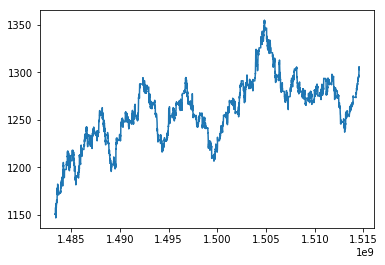

In [13]:
#A quick look at the dataframe time series using pyplot.plot(X_raw['XAUUSD']):
plt.plot(X_raw['XAUUSD'])

In [14]:
# Target
# We use as target one of the symbols rate, i.e. "XAUUSD". That is we try to predict next value of XAUUSD
lag = -1
y_raw = df2.loc[:,"XAUUSD"].shift(periods=lag)

In [15]:
y_raw

timestamp
1483322400    1150.67
1483326000    1150.67
1483329600    1150.67
1483333200    1150.67
1483336800    1150.67
1483340400    1150.67
1483344000    1150.67
1483347600    1150.67
1483351200    1150.67
1483354800    1150.67
1483358400    1150.67
1483362000    1150.67
1483365600    1150.67
1483369200    1150.67
1483372800    1150.67
1483376400    1150.67
1483380000    1150.30
1483383600    1150.69
1483387200    1156.09
1483390800    1157.15
1483394400    1156.88
1483398000    1157.33
1483401600    1157.77
1483405200    1157.46
1483408800    1153.10
1483412400    1151.48
1483416000    1148.10
1483419600    1146.78
1483423200    1148.56
1483426800    1148.72
               ...   
1514458800    1294.27
1514462400    1294.02
1514466000    1294.31
1514469600    1294.68
1514473200    1294.38
1514476800    1294.69
1514480400    1294.12
1514484000    1293.97
1514487600    1294.64
1514491200    1295.58
1514494800    1295.80
1514498400    1295.40
1514502000    1295.65
1514505600    1295.94


In [16]:
#
# Removal of Null values**
# Now since there still exists 'NaN' values in our target dataframe, and these are Null values,
# we have to do something about them. In here, I will just do the naive thing of replacing these NaNs
# with previous value because it is only the last value an error is negligible as such:

# Filling gaps forward
y_raw = y_raw.fillna(method='pad')
y_raw

# Drop timestamp variable (only when necessary)
#Ram print("Drop timestamp variable")
#Ram y_raw = data.drop(['timestamp'], 1)

timestamp
1483322400    1150.67
1483326000    1150.67
1483329600    1150.67
1483333200    1150.67
1483336800    1150.67
1483340400    1150.67
1483344000    1150.67
1483347600    1150.67
1483351200    1150.67
1483354800    1150.67
1483358400    1150.67
1483362000    1150.67
1483365600    1150.67
1483369200    1150.67
1483372800    1150.67
1483376400    1150.67
1483380000    1150.30
1483383600    1150.69
1483387200    1156.09
1483390800    1157.15
1483394400    1156.88
1483398000    1157.33
1483401600    1157.77
1483405200    1157.46
1483408800    1153.10
1483412400    1151.48
1483416000    1148.10
1483419600    1146.78
1483423200    1148.56
1483426800    1148.72
               ...   
1514458800    1294.27
1514462400    1294.02
1514466000    1294.31
1514469600    1294.68
1514473200    1294.38
1514476800    1294.69
1514480400    1294.12
1514484000    1293.97
1514487600    1294.64
1514491200    1295.58
1514494800    1295.80
1514498400    1295.40
1514502000    1295.65
1514505600    1295.94


## Split data

In [17]:
# split into train and test sets

# Total samples
nsamples = n

# Splitting into train (70%) and test (30%) sets
split = 70 # training split% ; test (100-split)%
jindex = nsamples*split//100 # Index for slicing the samples

# Samples in train
nsamples_train = jindex

# Samples in test
nsamples_test = nsamples - nsamples_train
print("Total number of samples: ",nsamples,"\nSamples in train set: ", nsamples_train,
      "\nSamples in test set: ",nsamples_test)

# Here are train and test samples
X_train = X_raw.values[:jindex, :]
y_train = y_raw.values[:jindex]

X_test = X_raw.values[jindex:, :]
y_test = y_raw.values[jindex:]

print("X_train.shape = ", X_train.shape, "y_train.shape =", y_train.shape, "\nX_test.shape =  ",
      X_test.shape, "y_test.shape = ", y_test.shape)


Total number of samples:  8679 
Samples in train set:  6075 
Samples in test set:  2604
X_train.shape =  (6075, 31) y_train.shape = (6075,) 
X_test.shape =   (2604, 31) y_test.shape =  (2604,)


In [18]:
#X_train as dataframe (optional, only for printing. See note in the beginning)
X_Train = pd.DataFrame(data=X_train)
X_Train.columns = X_raw.columns
print("X_train")
X_Train

X_train


,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
0,1.05155,1.03924,0.72074,84.258,1.07186,0.85184,122.966,1.25839,144.236,1.23400,...,1.51584,1.71140,1.65760,1.77865,0.93094,0.70579,80.960,15.883,1150.67,2241.00
1,1.05152,1.03608,0.71891,84.202,1.07199,0.85157,123.163,1.25825,144.595,1.23433,...,1.51573,1.71656,1.65910,1.77881,0.93154,0.70649,81.170,15.883,1150.67,2241.00
2,1.04889,1.03603,0.71750,84.217,1.07144,0.84993,123.111,1.26015,144.812,1.23364,...,1.51382,1.71926,1.65383,1.78057,0.92817,0.70687,81.240,15.883,1150.67,2241.00
3,1.04866,1.03611,0.71701,84.172,1.07140,0.85059,123.128,1.25899,144.725,1.23254,...,1.51576,1.71859,1.65222,1.78131,0.92698,0.70633,81.184,15.883,1150.67,2241.00
4,1.04805,1.03606,0.71778,84.221,1.07183,0.85169,122.980,1.25784,144.351,1.23011,...,1.51246,1.71370,1.65062,1.77544,0.92896,0.70795,81.204,15.883,1150.67,2241.00
5,1.04782,1.03568,0.71772,84.254,1.07134,0.85166,123.005,1.25731,144.372,1.22994,...,1.51195,1.71307,1.65114,1.77450,0.92954,0.70766,81.237,15.883,1150.67,2241.00
6,1.04655,1.03599,0.71761,84.297,1.07100,0.85130,122.946,1.25765,144.387,1.22904,...,1.51043,1.71221,1.65046,1.77375,0.92973,0.70855,81.332,15.883,1150.67,2241.00
7,1.04655,1.03480,0.71728,84.155,1.07110,0.85168,122.789,1.25709,144.164,1.22857,...,1.50970,1.71236,1.65043,1.77227,0.93100,0.70900,81.283,15.883,1150.67,2241.00
8,1.04718,1.03359,0.71845,84.312,1.07134,0.85193,122.897,1.25634,144.227,1.22885,...,1.50634,1.70967,1.64825,1.76754,0.93260,0.71065,81.551,15.883,1150.67,2241.00
9,1.04696,1.03366,0.71846,84.318,1.07134,0.85152,122.875,1.25775,144.277,1.22919,...,1.50582,1.71072,1.64941,1.76835,0.93280,0.71090,81.560,15.883,1150.67,2241.00


In [19]:
#X_test as dataframe (optional, only for printing. See note in the beginning)
X_Test = pd.DataFrame(data=X_test)
X_Test.columns = X_raw.columns
print("X_test")
X_Test

X_test


,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
0,1.19578,1.09851,0.80288,88.085,1.14416,0.90125,131.191,1.26945,145.561,1.32678,...,1.63594,1.65241,1.60775,1.81533,0.88565,0.69925,80.182,17.791,1326.34,2490.75
1,1.19614,1.09953,0.80275,88.058,1.14519,0.90206,131.208,1.26944,145.449,1.32595,...,1.63819,1.65175,1.60777,1.81606,0.88523,0.69895,80.084,17.795,1326.37,2490.25
2,1.19365,1.09878,0.80263,88.133,1.14539,0.89908,131.074,1.27397,145.785,1.32761,...,1.63403,1.65402,1.61047,1.81740,0.88600,0.70089,80.208,17.738,1323.60,2491.50
3,1.19318,1.10105,0.80242,88.140,1.14431,0.89896,131.063,1.27284,145.786,1.32723,...,1.63725,1.65401,1.61183,1.82118,0.88500,0.69888,80.043,17.795,1325.55,2492.00
4,1.19296,1.10064,0.80168,88.150,1.14647,0.89998,131.173,1.27381,145.750,1.32555,...,1.63778,1.65331,1.61062,1.81990,0.88489,0.69994,80.084,17.786,1325.43,2490.50
5,1.19462,1.10157,0.80184,88.236,1.14733,0.90103,131.454,1.27327,145.890,1.32577,...,1.64118,1.65333,1.61067,1.82138,0.88425,0.69904,80.092,17.829,1326.65,2493.13
6,1.19538,1.10092,0.80341,88.309,1.14719,0.90131,131.389,1.27271,145.768,1.32617,...,1.63795,1.65050,1.61040,1.81718,0.88613,0.70030,80.209,17.826,1327.29,2490.75
7,1.19675,1.10215,0.80411,88.464,1.14845,0.90122,131.667,1.27420,146.092,1.32788,...,1.64028,1.65127,1.61399,1.82000,0.88670,0.70005,80.261,17.830,1327.19,2492.50
8,1.19628,1.10149,0.80307,88.369,1.14825,0.90119,131.641,1.27396,146.063,1.32738,...,1.64076,1.65268,1.61441,1.82046,0.88666,0.69969,80.221,17.846,1328.13,2494.50
9,1.19601,1.10063,0.80242,88.308,1.14873,0.90030,131.627,1.27586,146.195,1.32837,...,1.64048,1.65546,1.61630,1.82197,0.88700,0.70018,80.228,17.834,1328.40,2493.50


## Transform features

**Note**

Becareful not to write `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a great difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, this is not always the case in Forex market data, as has been well stablished in literature. The correct way is to re-use parameters from the training set if we are doing any kind of transformation. So, the test set should basically stand for "new, unseen" data.


In [20]:
# Scale data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

y_train_std = sc.fit_transform(y_train.reshape(-1, 1)) #Reshape to get the right tensor dimension 
y_test_std = sc.transform(y_test.reshape(-1, 1)) #Reshape to get the right tensor dimension 

In [21]:
print("Mean:",sc.mean_)
print("Variance",sc.var_)

Mean: [1248.6151177]
Variance [1253.0292182]


In [22]:
#X_train_std as dataframe (optional, only for printing. See note in the beginning)
X_Train_std = pd.DataFrame(data=X_train_std)
X_Train_std.columns = X_Train.columns
print("X_train_std")
X_Train_std

X_train_std


,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
0,-1.224742,-1.555891,-2.288290,-0.665046,-0.730431,-0.893555,-0.239328,0.468459,0.774780,-1.261199,...,-0.673191,1.158946,-0.200571,0.022696,-0.396873,0.154414,0.486752,-1.865377,-2.765494,-2.244887
1,-1.225386,-1.721135,-2.384747,-0.695522,-0.725437,-0.905391,-0.192994,0.459918,0.906494,-1.249807,...,-0.675329,1.282770,-0.169755,0.026263,-0.362513,0.207172,0.589981,-1.865377,-2.765494,-2.244887
2,-1.281865,-1.723750,-2.459067,-0.687358,-0.746563,-0.977283,-0.205225,0.575832,0.986110,-1.273625,...,-0.712450,1.347562,-0.278020,0.065500,-0.555501,0.235812,0.624390,-1.865377,-2.765494,-2.244887
3,-1.286804,-1.719566,-2.484894,-0.711848,-0.748100,-0.948351,-0.201226,0.505064,0.954190,-1.311596,...,-0.674746,1.331484,-0.311095,0.081998,-0.623648,0.195113,0.596863,-1.865377,-2.765494,-2.244887
4,-1.299904,-1.722181,-2.444308,-0.685182,-0.731583,-0.900131,-0.236035,0.434906,0.816973,-1.395477,...,-0.738882,1.214139,-0.343964,-0.048867,-0.510261,0.317210,0.606694,-1.865377,-2.765494,-2.244887
5,-1.304843,-1.742052,-2.447471,-0.667223,-0.750404,-0.901446,-0.230156,0.402572,0.824677,-1.401346,...,-0.748794,1.199021,-0.333282,-0.069823,-0.477046,0.295353,0.622916,-1.865377,-2.765494,-2.244887
6,-1.332116,-1.725841,-2.453269,-0.643822,-0.763464,-0.917227,-0.244032,0.423314,0.830181,-1.432413,...,-0.778336,1.178383,-0.347251,-0.086544,-0.466165,0.362431,0.669615,-1.865377,-2.765494,-2.244887
7,-1.332116,-1.788069,-2.470663,-0.721099,-0.759623,-0.900569,-0.280958,0.389150,0.748364,-1.448637,...,-0.792524,1.181983,-0.347868,-0.119539,-0.393437,0.396347,0.645528,-1.865377,-2.765494,-2.244887
8,-1.318587,-1.851343,-2.408993,-0.635659,-0.750404,-0.889610,-0.255557,0.343395,0.771478,-1.438971,...,-0.857827,1.117431,-0.392653,-0.224989,-0.301810,0.520705,0.777268,-1.865377,-2.765494,-2.244887
9,-1.323311,-1.847683,-2.408466,-0.632393,-0.750404,-0.907583,-0.260731,0.429415,0.789823,-1.427235,...,-0.867933,1.142628,-0.368822,-0.206931,-0.290357,0.539548,0.781692,-1.865377,-2.765494,-2.244887


In [23]:
#X_train_std as dataframe (optional, only for printing. See note in the beginning)
X_Test_std = pd.DataFrame(data=X_test_std)
X_Test_std.columns = X_Test.columns

print("X_test_std")
X_Test_std

X_test_std


,EURUSD,AUDNZD,AUDUSD,AUDJPY,EURCHF,EURGBP,EURJPY,GBPCHF,GBPJPY,GBPUSD,...,EURNZD,GBPAUD,GBPCAD,GBPNZD,NZDCAD,NZDCHF,NZDJPY,XAGUSD,XAUUSD,SPXUSD
0,1.872583,1.543488,2.041224,1.417636,2.046656,1.272404,1.695165,1.143198,1.260913,1.941469,...,1.660995,-0.256635,-1.224666,0.840435,-2.990479,-0.338496,0.104313,0.885567,2.196038,1.654966
1,1.880314,1.596827,2.034372,1.402942,2.086219,1.307911,1.699163,1.142588,1.219821,1.912818,...,1.704725,-0.272473,-1.224255,0.856709,-3.014531,-0.361107,0.056140,0.891335,2.196885,1.647159
2,1.826842,1.557607,2.028047,1.443758,2.093901,1.177279,1.667647,1.418951,1.343097,1.970120,...,1.623874,-0.218000,-1.168788,0.886583,-2.970436,-0.214892,0.117094,0.809152,2.118651,1.666678
3,1.816749,1.676311,2.016978,1.447567,2.052418,1.172018,1.665059,1.350013,1.343464,1.957003,...,1.686456,-0.218240,-1.140848,0.970854,-3.027702,-0.366382,0.035985,0.891335,2.173726,1.674485
4,1.812024,1.654871,1.977974,1.453009,2.135385,1.216731,1.690931,1.409190,1.330255,1.899011,...,1.696756,-0.235038,-1.165706,0.942317,-3.034002,-0.286492,0.056140,0.878358,2.170336,1.651063
5,1.847673,1.703503,1.986407,1.499811,2.168418,1.262760,1.757021,1.376246,1.381620,1.906605,...,1.762837,-0.234558,-1.164679,0.975312,-3.070652,-0.354324,0.060072,0.940356,2.204794,1.692130
6,1.863993,1.669513,2.069160,1.539538,2.163040,1.275034,1.741734,1.342082,1.336859,1.920413,...,1.700060,-0.302469,-1.170226,0.881678,-2.962991,-0.259359,0.117586,0.936030,2.222869,1.654966
7,1.893414,1.733833,2.106056,1.623890,2.211438,1.271089,1.807118,1.432982,1.455733,1.979440,...,1.745345,-0.283992,-1.096474,0.944547,-2.930349,-0.278201,0.143147,0.941797,2.220045,1.682293
8,1.883321,1.699320,2.051239,1.572191,2.203756,1.269773,1.801003,1.418341,1.445093,1.962181,...,1.754674,-0.250156,-1.087846,0.954802,-2.932640,-0.305334,0.123484,0.964866,2.246594,1.713523
9,1.877523,1.654348,2.016978,1.538994,2.222193,1.230759,1.797710,1.534254,1.493523,1.996354,...,1.749232,-0.183444,-1.049019,0.988466,-2.913169,-0.268403,0.126925,0.947565,2.254220,1.697908


In [24]:
#y_train as panda dataframe (optional, only for printing. See note in the beginning)
y_Train = pd.DataFrame(data=y_train)
y_Train.columns=["XAUUSDopen"]
y_Train

,XAUUSDopen
0,1150.67
1,1150.67
2,1150.67
3,1150.67
4,1150.67
5,1150.67
6,1150.67
7,1150.67
8,1150.67
9,1150.67


In [25]:
#y_train as panda dataframe (optional, only for printing. See note in the beginning)
y_Test = pd.DataFrame(data=y_test)
y_Test.columns=["XAUUSDopen"]
y_Test

,XAUUSDopen
0,1326.37
1,1323.60
2,1325.55
3,1325.43
4,1326.65
5,1327.29
6,1327.19
7,1328.13
8,1328.40
9,1330.77


In [26]:
#y_train_std as panda dataframe (optional, only for printing. See note in the beginning)
y_Train_std = pd.DataFrame(data=y_train_std)
y_Train_std.columns=["XAUUSDopen"]
y_Train_std

,XAUUSDopen
0,-2.766956
1,-2.766956
2,-2.766956
3,-2.766956
4,-2.766956
5,-2.766956
6,-2.766956
7,-2.766956
8,-2.766956
9,-2.766956


In [27]:
#y_train_std as panda dataframe (optional, only for printing. See note in the beginning)
y_Test_std = pd.DataFrame(data=y_train_std)
y_Test_std.columns=["XAUUSDopen"]
y_Test_std

,XAUUSDopen
0,-2.766956
1,-2.766956
2,-2.766956
3,-2.766956
4,-2.766956
5,-2.766956
6,-2.766956
7,-2.766956
8,-2.766956
9,-2.766956


After the transformation, we must decide if we want to feed the training cycle with the vector "y" transformed (y_train_std and_test_std) or not (y_train and_test). In any case, the vector that we will introduce will be the vector y_train_input and the y_test_input.
In our case we will use the transformed vector, so the input vectors will be:

In [28]:
# Shape of tensors
print("X_train_std.shape = ", X_train_std.shape, "y_train.shape =", y_train.shape,
      "\nX_train_std.shape =  ", X_train_std.shape, "y_test.shape = ", y_test.shape)


X_train_std.shape =  (6075, 31) y_train.shape = (6075,) 
X_train_std.shape =   (6075, 31) y_test.shape =  (2604,)


In [29]:
# Shape of tensors
print("X_train_std.shape = ", X_train_std.shape, "y_train_std.shape =", y_train_std.shape,
      "\nX_train_std.shape =  ", X_train_std.shape, "y_test_std.shape = ", y_test_std.shape)


X_train_std.shape =  (6075, 31) y_train_std.shape = (6075, 1) 
X_train_std.shape =   (6075, 31) y_test_std.shape =  (2604, 1)


In [30]:
# Number of samples in the train set
ntrain = y_train_std.shape[0]
# Number of samples in the test set
ntest = y_test_std.shape[0]

# Reshaping to get the righ training input tensor dimension.
y_train_input = y_train_std.reshape(ntrain,)
y_test_input = y_test_std.reshape(ntest,)

In [31]:
y_train_input

array([-2.76695562, -2.76695562, -2.76695562, ...,  2.19177771,
        2.21437776,  2.19573272])

In [32]:
y_test_input

array([2.19658022, 2.11832755, 2.17341517, ..., 1.53439878, 1.54202629,
       1.54202629])

## Implement the model

![deep_network_model](../images/deep_network_model_avatar.jpg)



The progress of the model can be saved during and after training. This means that a model can be resumed where it left off and avoid long training times. Saving also means that you can share your model and others can recreate your work.

We will illustrate how to create a multiple fully connected hidden layer NN, save it and make predictions with trained model after reload it.

We will use Forex data for this exercise.

We will build a four-hidden layer neural network  to predict the next close price of GOLD, from the other Forex pair four features of the precedent period (open, high, low and close). For the sake of simplicity, we have really used only the "open" price.

This is a practical exercise to learn how to make predictions with TensorFlow. Also, in the meantime, you will be able to elaborate on your own systems.

![nn](../images/nn.png)

As can be seen, this neural network is not exactly the most complex one. That is to say that it is not precisely  [AmoebaNet-B](https://ai.googleblog.com/2018/03/using-evolutionary-automl-to-discover.html) with 557 million model parameters, but it is enough to clarify our concepts.

In [33]:
# Clears the default graph stack and resets the global default graph
ops.reset_default_graph()


In [34]:
# make results reproducible
seed = 2 #ram 2
tf.set_random_seed(seed)
np.random.seed(seed)  


# Parameters
learning_rate = 0.004
epsilon = 0.00001
batch_size = 1
n_features = X_train.shape[1]#  Number of features in training data
epochs = 5000
display_step = 50
model_path = model_dir+"08_Gold_Prediction-60Min"
production_model_path = production_dir+"models/"+"08_Gold_Prediction-60Min"
n_classes = 1

# Network Parameters
# See figure of the model
d0 = D = n_features # Layer 0 (Input layer number of features)
d1 = 60 # Layer 1 (1024 hidden nodes)
d2 = 20 # Layer 2 (512 hidden nodes) 
d3 = 5 # Layer 3 (256 hidden nodes)
d4 = 3 # Layer 4 (128 hidden nodes)
d5 = C = 1 # Layer 5 (Output layer)

# tf Graph input
print("Placeholders")
X = tf.placeholder(dtype=tf.float32, shape=[None, n_features], name="X")
y = tf.placeholder(dtype=tf.float32, shape=[None,n_classes], name="y")


# Initializers
print("Initializers")
sigma = 3.0
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution='uniform', scale=sigma)
bias_initializer = tf.zeros_initializer()

# Create model
def multilayer_perceptron(X, variables):
    # Hidden layer with ReLU activation
    layer_1 = tf.nn.relu(tf.add(tf.matmul(X, variables['W1']), variables['bias1']), name="layer_1")
    # Hidden layer with ReLU activation
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, variables['W2']), variables['bias2']), name="layer_2")
    # Hidden layer with ReLU activation
    layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, variables['W3']), variables['bias3']), name="layer_3")
    # Hidden layer with ReLU activation
    layer_4 = tf.nn.relu(tf.add(tf.matmul(layer_3, variables['W4']), variables['bias4']), name="layer_4")
    # Output layer with ReLU activation
    out_layer = tf.nn.relu(tf.add(tf.matmul(layer_4, variables['W5']), variables['bias5']), name="out_layer")
    return out_layer

# Store layers weight & bias
variables = {
    'W1': tf.Variable(weight_initializer([n_features, d1]), name="W1"), # inputs -> d1 hidden neurons
    'bias1': tf.Variable(bias_initializer([d1]), name="bias1"), # one biases for each d1 hidden neurons
    'W2': tf.Variable(weight_initializer([d1, d2]), name="W2"), # d1 hidden inputs -> d2 hidden neurons
    'bias2': tf.Variable(bias_initializer([d2]), name="bias2"), # one biases for each d2 hidden neurons
    'W3': tf.Variable(weight_initializer([d2, d3]), name="W3"), ## d2 hidden inputs -> d3 hidden neurons
    'bias3': tf.Variable(bias_initializer([d3]), name="bias3"), # one biases for each d3 hidden neurons
    'W4': tf.Variable(weight_initializer([d3, d4]), name="W4"), ## d3 hidden inputs -> d4 hidden neurons
    'bias4': tf.Variable(bias_initializer([d4]), name="bias4"), # one biases for each d4 hidden neurons
    'W5': tf.Variable(weight_initializer([d4, d5]), name="W5"), # d4 hidden inputs -> 1 output
    'bias5': tf.Variable(bias_initializer([d5]), name="bias5") # 1 bias for the output
}

# Construct model
y_hat = multilayer_perceptron(X, variables)

# Cost function
print("Cost function")
mse = tf.reduce_mean(tf.squared_difference(y_hat, y))

# Optimizer
print("Optimizer")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon).minimize(mse)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

def generate_one_epoch(X_train, y_train, batch_size):
    num_batches = int(len(X_train)) // batch_size
    if batch_size * num_batches < len(X_train):
        num_batches += 1

    batch_indices = range(num_batches)
    batch_n = np.random.permutation(batch_indices)
    for j in batch_n:
        batch_X = X_train[j * batch_size: (j + 1) * batch_size]
        batch_y = y_train[j * batch_size: (j + 1) * batch_size]

    yield batch_X, batch_y



Placeholders
Initializers
Cost function
Optimizer


## Train the model  and Evaluate the model

In [35]:
# Fit neural net
print("Fit neural net")

with tf.Session() as sess:
    
    # Writer to record image, scalar, histogram and graph for display in tensorboard
    writer = tf.summary.FileWriter("/tmp/tensorflow_logs", sess.graph)  # create writer
    writer.add_graph(sess.graph)

    # Run the initializer
    #sess.run(init)
    sess.run(tf.global_variables_initializer())
    
    # Restore model weights from previously saved model
    #Ram saver.restore(sess, model_path)
    #Ram print("Model restored from file: %s" % model_path)
    '''
    # Try to restore a model if any.
    try:
        saver.restore(sess, model_path)
        print("Model restored from file: %s" % model_path)
    except Exception:
        print("No model file to restore")
        pass
    '''
    # Training cycle
    mse_train = []
    mse_test = []

    
    # Run
    print("Run")
    printcounter = 0
    for e in range(epochs):
        #sess.run(tf.global_variables_initializer())
        # Minibatch training
        
        for batch_X, batch_y in generate_one_epoch(X_train_std, y_train_input, batch_size):
            # Run optimizer with batch
            sess.run(optimizer, feed_dict={X: batch_X, y: np.transpose([batch_y])})
            #Ram print("batch_X",batch_X)
            #Ram print("batch_y",batch_y)
         
        # Show progress
        if (printcounter == display_step):
            
            printcounter = 0
            print("Epoch: ", e)
            # MSE train and test
            mse_train.append(sess.run(mse, feed_dict={X: X_train_std, y: np.transpose([y_train_input])}))
            mse_test.append(sess.run(mse, feed_dict={X: X_test_std, y: np.transpose([y_test_input])}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
        
        printcounter += 1
        
    # Print final MSE after Training
    mse_final = sess.run(mse, feed_dict={X: X_test_std, y: np.transpose([y_test_input])})
    print("MSE Final",mse_final)
    
    # Close writer
    writer.flush()
    writer.close()
        
    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)
    print("First Optimization Finished!")


Fit neural net
Run
Epoch:  50
MSE Train:  0.66133934
MSE Test:  2.0214076
Epoch:  100
MSE Train:  1.2463222
MSE Test:  4.8861437
Epoch:  150
MSE Train:  0.5524249
MSE Test:  1.5428063
Epoch:  200
MSE Train:  0.5269637
MSE Test:  0.9128028
Epoch:  250
MSE Train:  0.504704
MSE Test:  2.006605
Epoch:  300
MSE Train:  0.5011368
MSE Test:  1.3647156
Epoch:  350
MSE Train:  0.5088436
MSE Test:  0.7686715
Epoch:  400
MSE Train:  0.52742594
MSE Test:  0.82534343
Epoch:  450
MSE Train:  0.50134337
MSE Test:  1.0851101
Epoch:  500
MSE Train:  0.49415585
MSE Test:  1.1942579
Epoch:  550
MSE Train:  0.49791518
MSE Test:  0.9910784
Epoch:  600
MSE Train:  0.4984136
MSE Test:  0.87677443
Epoch:  650
MSE Train:  0.5154898
MSE Test:  1.3149083
Epoch:  700
MSE Train:  0.5291795
MSE Test:  0.95405865
Epoch:  750
MSE Train:  0.53603995
MSE Test:  0.8789939
Epoch:  800
MSE Train:  0.49764425
MSE Test:  0.8629062
Epoch:  850
MSE Train:  0.5047349
MSE Test:  0.7157471
Epoch:  900
MSE Train:  0.49784207
MSE 

In [36]:
batch_y.shape

(1,)

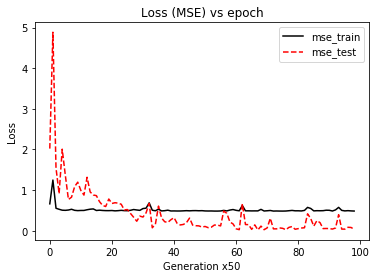

In [37]:
%matplotlib inline
# Plot loss (MSE) over time
plt.plot(mse_train, 'k-', label='mse_train')
plt.plot(mse_test, 'r--', label='mse_test')
plt.title('Loss (MSE) vs epoch')
plt.legend(loc='upper right')
plt.xlabel('Generation x'+str(display_step))
plt.ylabel('Loss')
plt.show()

Wait!, mse_train becomes lower than mse_test, why? Recall that the MSE is only a point estimate sampled from a distribution of possible MSEs and what exact data entered in your training set against your set of tests affects this point estimate. As an exercise, I suggest that you try to get an idea of what the underlying distribution looks like to be able to test whether the training MSE is significantly greater than the test MSE. Also, remember that only one year's data has been used! that there are very few data.

One way to do this is to take your training set and randomly select, for example, 80% or 85% of it for a new set of sublearning. Then, of what is left, you have a new set of subtests. Record the MSE for both this subtraining and for the subtests. Then repeat this process many times and trace the distribution.

### Tensorboard Graph


What follows is the graph we have executed and all data about it. Note the "save" label and the several layers.


![graph_4](../images/graph_4.png)


### Saving a Tensorflow model

So, now we have our model saved.

Tensorflow model has four main files:
* a) Meta graph:
This is a protocol buffer which saves the complete Tensorflow graph; i.e. all variables, operations, collections etc. This file has .meta extension.


* b) y c) Checkpoint files:
It is a binary file which contains all the values of the weights, biases, gradients and all the other variables saved. Tensorflow has changed from version 0.11. Instead of a single .ckpt file, we have now two files: .index and .data file that contains our training variables. 


* d) Along with this, Tensorflow also has a file named checkpoint which simply keeps a record of latest checkpoint files saved.


## Predict

Finally, we can use the model to make some predictions.

Starting prediction session...
INFO:tensorflow:Restoring parameters from ../models/08_Gold_Prediction-60Min
Model restored from file: ../models/08_Gold_Prediction-60Min
[[2.3185585]
 [2.3329074]
 [2.2485995]
 ...
 [1.1020833]
 [1.080542 ]
 [1.0774844]]


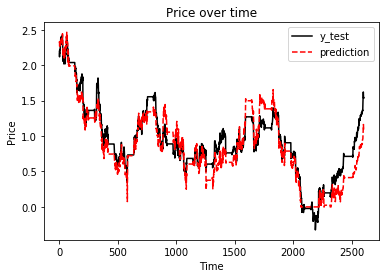

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/home/parrondo/PRODUCTION/models/08_Gold_Prediction-60Min/11/saved_model.pb'


In [38]:
# Running a new session for predictions and export model to production
print("Starting prediction session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Try to restore a model if any.
    try:
        saver.restore(sess, model_path)
        print("Model restored from file: %s" % model_path)
        # We try to predict the close price of test samples
        feed_dict = {X: X_test_std}
        
        prediction = sess.run(y_hat, feed_dict)
        print(prediction) 

        %matplotlib inline
        # Plot Prices over time
        plt.plot(y_test_std, 'k-', label='y_test')
        plt.plot(prediction, 'r--', label='prediction')
        plt.title('Price over time')
        plt.legend(loc='upper right')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.show()
        
        if to_production:
            # Pick out the model input and output
            X_tensor = sess.graph.get_tensor_by_name("X"+ ':0')
            y_tensor = sess.graph.get_tensor_by_name("out_layer" + ':0')

            model_input = build_tensor_info(X_tensor)
            model_output = build_tensor_info(y_tensor)
            
            # Create a signature definition for tfserving
            signature_definition = signature_def_utils.build_signature_def(
                inputs={"X": model_input},
                outputs={"out_layer": model_output},
                method_name=signature_constants.PREDICT_METHOD_NAME)

            model_version = 1
            export_model_dir = production_model_path+"/"+str(model_version)
            while os.path.exists(export_model_dir):
                model_version += 1
                export_model_dir = production_model_path+"/"+str(model_version)       
    
            builder = saved_model_builder.SavedModelBuilder(export_model_dir)  
            builder.add_meta_graph_and_variables(sess,
                                                 [tag_constants.SERVING],
                                                 signature_def_map={
                                                     signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                                                     signature_definition})

            # Save the model so we can serve it with a model server :)
            builder.save()

    except Exception:
        print("Unexpected error:", sys.exc_info()[0])
        pass



Remember this price is transformed price. If you want to know the real price you must revert the transformation. Below is an example of reversion where you can see the tipical price of Gold pound in USD on 2017.

In [39]:
y_hat_rev = sc.inverse_transform(prediction)
y_hat_rev


array([[1330.6877],
       [1331.1957],
       [1328.2114],
       ...,
       [1287.6268],
       [1286.8643],
       [1286.7561]], dtype=float32)

In [40]:
dfvisual = pd.DataFrame()
dfvisual["y_test_std"] = y_test_input
dfvisual["prediction"]= prediction
dfvisual["Abs.error"]=dfvisual["y_test_std"]-dfvisual["prediction"]
dfvisual["Relat.error"]=abs(dfvisual["Abs.error"]/dfvisual["y_test_std"])*100

dfvisual["y_test"] = y_test
dfvisual["prediction_rev"]= y_hat_rev
dfvisual["Abs.error_rev"]=dfvisual["y_test"]-dfvisual["prediction_rev"]
dfvisual["Relat.error_rev"]=abs(dfvisual["Abs.error_rev"]/dfvisual["y_test"])*100
dfvisual

,y_test_std,prediction,Abs.error,Relat.error,y_test,prediction_rev,Abs.error_rev,Relat.error_rev
0,2.196580,2.318558,-0.121978,5.553097,1326.37,1330.687744,-4.317744,0.325531
1,2.118328,2.332907,-0.214580,10.129684,1323.60,1331.195679,-7.595679,0.573865
2,2.173415,2.248600,-0.075184,3.459273,1325.55,1328.211426,-2.661426,0.200779
3,2.170025,2.297498,-0.127473,5.874266,1325.43,1329.942261,-4.512261,0.340437
4,2.204490,2.279125,-0.074635,3.385589,1326.65,1329.291992,-2.641992,0.199148
5,2.222570,2.311989,-0.089419,4.023215,1327.29,1330.455200,-3.165200,0.238471
6,2.219745,2.308049,-0.088303,3.978089,1327.19,1330.315796,-3.125796,0.235520
7,2.246300,2.297558,-0.051257,2.281852,1328.13,1329.944458,-1.814458,0.136618
8,2.253928,2.306988,-0.053060,2.354119,1328.40,1330.278198,-1.878198,0.141388
9,2.320880,2.298412,0.022468,0.968099,1330.77,1329.974609,0.795391,0.059769


In [41]:
# Mean relative error
dfvisual["Relat.error_rev"].mean()

0.4114874168732872

In [42]:
dfvisual["Abs.error_rev"].mean()

2.2686865478140428

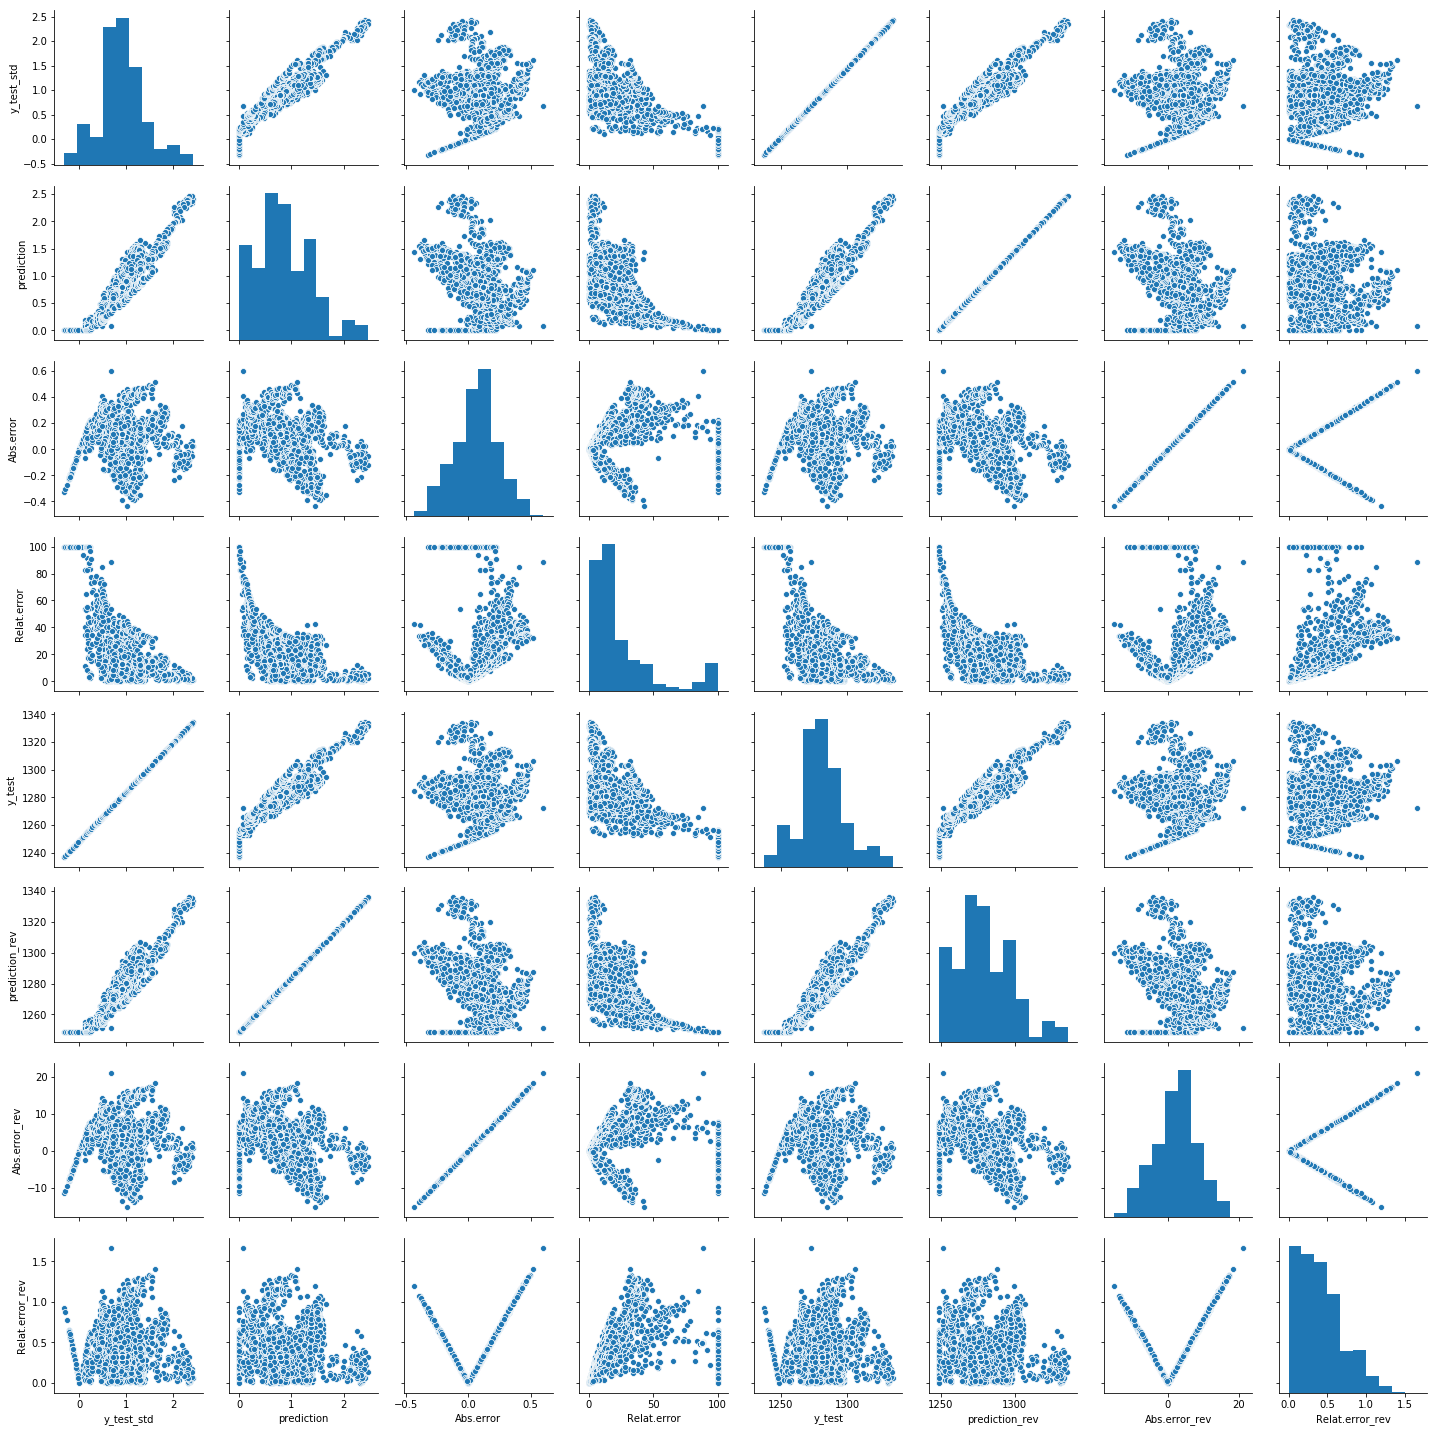

In [43]:
# Seaborn visualization library
import seaborn as sns

# Create the default pairplot
sns.pairplot(dfvisual)

OK, better results, but still not very good results. We could try to improve them with a deeper network (more layers) or retouching the net parameters and number of neurons. That is another story.